In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split

color_palete = sns.color_palette("husl", 8)

# Data Import and Simple Cleaning

In [2]:
train_ = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv')
test_ = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv')
original = pd.read_csv('/kaggle/input/media-campaign-cost-prediction/train_dataset.csv')

In [3]:
train_df = pd.concat([train_,original], axis = 0).reset_index(drop = True)
train_df.drop(columns = ['id'],inplace = True)
test_df = test_.drop(columns = ['id'])
train_df = train_df.drop_duplicates()

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411664 entries, 0 to 411698
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   store_sales(in millions)    411664 non-null  float64
 1   unit_sales(in millions)     411664 non-null  float64
 2   total_children              411664 non-null  float64
 3   num_children_at_home        411664 non-null  float64
 4   avg_cars_at home(approx).1  411664 non-null  float64
 5   gross_weight                411664 non-null  float64
 6   recyclable_package          411664 non-null  float64
 7   low_fat                     411664 non-null  float64
 8   units_per_case              411664 non-null  float64
 9   store_sqft                  411664 non-null  float64
 10  coffee_bar                  411664 non-null  float64
 11  video_store                 411664 non-null  float64
 12  salad_bar                   411664 non-null  float64
 13  prepared_food 

In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_sales(in millions),411664.0,6.361640,3.328597,0.51,3.74,5.80,8.43,22.92
unit_sales(in millions),411664.0,3.049783,0.790281,1.00,3.00,3.00,4.00,6.00
total_children,411664.0,2.466684,1.489281,0.00,1.00,2.00,4.00,5.00
num_children_at_home,411664.0,0.707208,1.227109,0.00,0.00,0.00,1.00,5.00
avg_cars_at home(approx).1,411664.0,2.203265,1.087431,0.00,1.00,2.00,3.00,4.00
gross_weight,411664.0,13.820067,4.615738,6.00,9.71,13.60,17.70,21.90
recyclable_package,411664.0,0.566887,0.495507,0.00,0.00,1.00,1.00,1.00
low_fat,411664.0,0.330704,0.470467,0.00,0.00,0.00,1.00,1.00
units_per_case,411664.0,18.958141,10.219244,1.00,10.00,20.00,28.00,36.00
store_sqft,411664.0,28155.232372,5936.602256,20319.00,23593.00,27694.00,33858.00,39696.00


In [6]:
train_df.nunique()

store_sales(in millions)      1049
unit_sales(in millions)          6
total_children                   6
num_children_at_home             6
avg_cars_at home(approx).1       5
gross_weight                   384
recyclable_package               2
low_fat                          2
units_per_case                  36
store_sqft                      20
coffee_bar                       2
video_store                      2
salad_bar                        2
prepared_food                    2
florist                          2
cost                           328
dtype: int64

In [7]:
cat = [
    'unit_sales(in millions)',
    'total_children',
    'num_children_at_home',
    'avg_cars_at home(approx).1',
    'recyclable_package',
    'low_fat',
    'coffee_bar',
    'video_store',
    'salad_bar',
    'prepared_food',
    'florist'
]

# EDA

<AxesSubplot:>

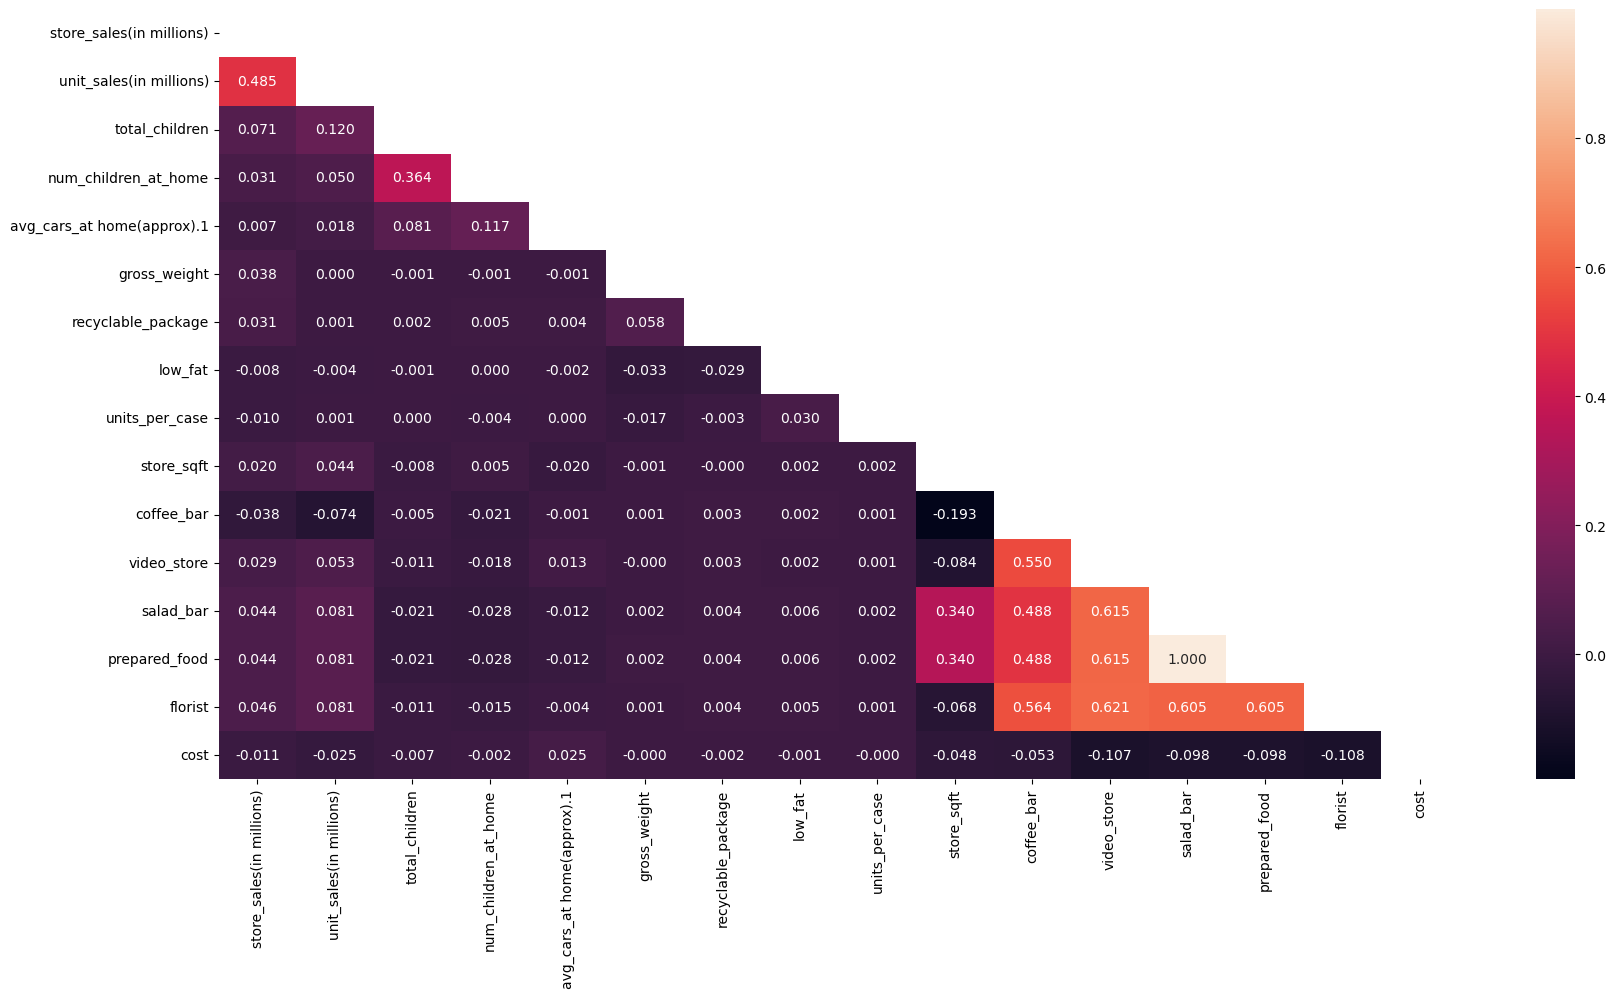

In [8]:
fig, ax = plt.subplots(figsize = [20,10])
mask = np.triu(train_df.corr())
sns.heatmap(train_df.corr(),fmt='.3f',annot = True, ax = ax, mask = mask)

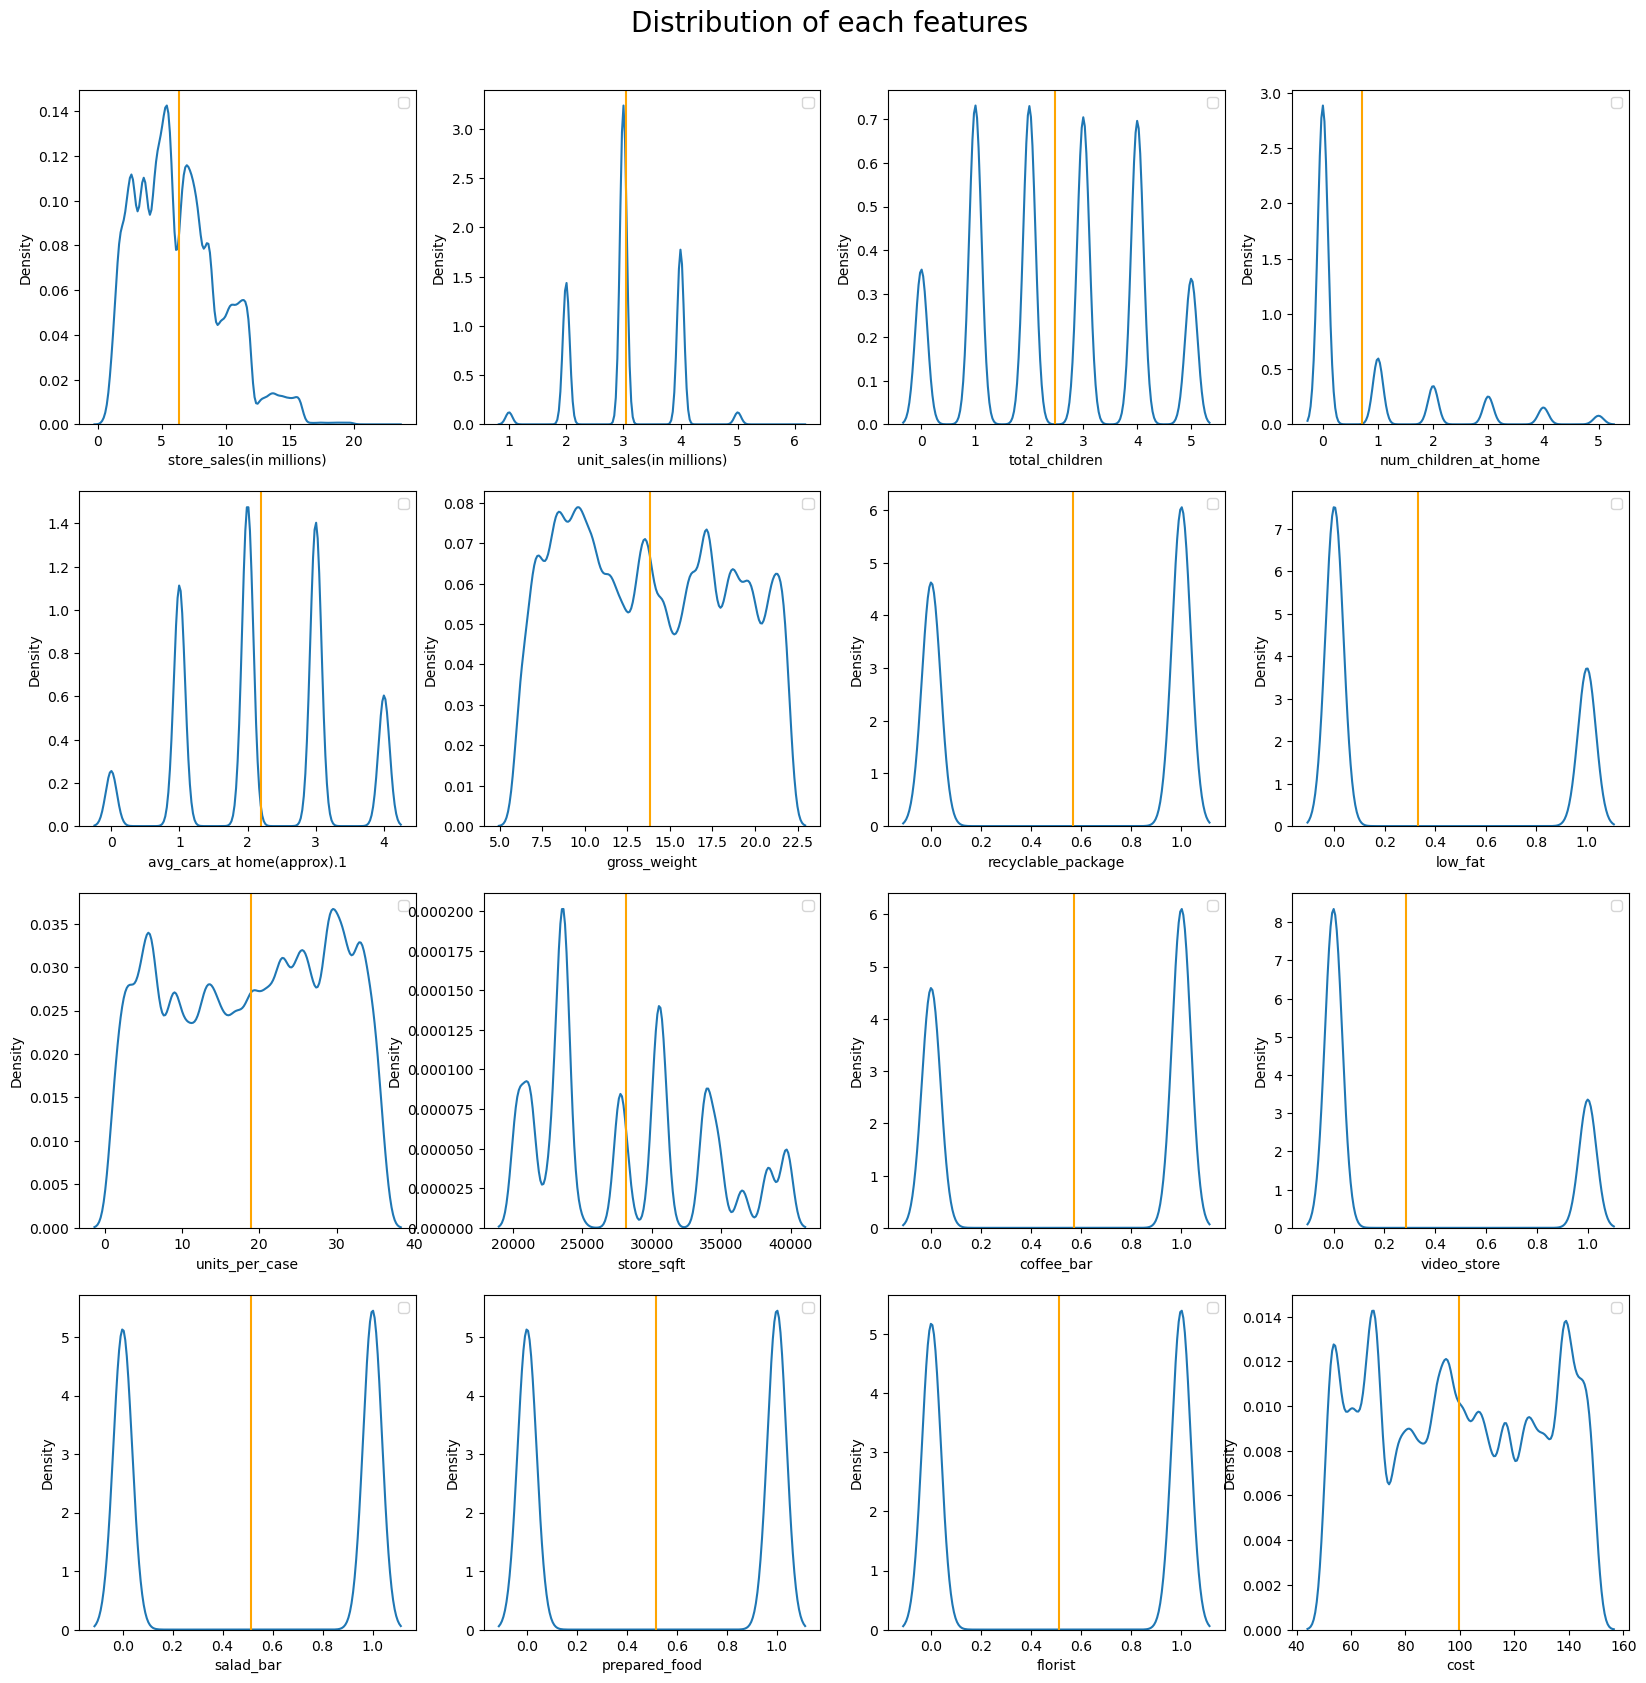

In [9]:
def multi_kde(data, grid, figsize = (20,20)):
    x,y = grid[1],grid[0]
    fig, axes = plt.subplots(y, x, figsize=figsize)
    for i,col in enumerate(data.columns):
        try:
            ax = axes[i//axes.shape[1],i%axes.shape[1]]
        except IndexError:
            ax = axes[i]
        kde = sns.kdeplot(data=train_df[col],\
                    ax = ax,fill = False, warn_singular=False)
        ax.legend(loc="upper right")

        # Draw mean straight lines
        mean = train_df[col].mean()
        ax.axvline(mean, color = 'orange')

    fig.suptitle('Distribution of each features',y = .92, fontsize=20)

multi_kde(train_df,(4,4))

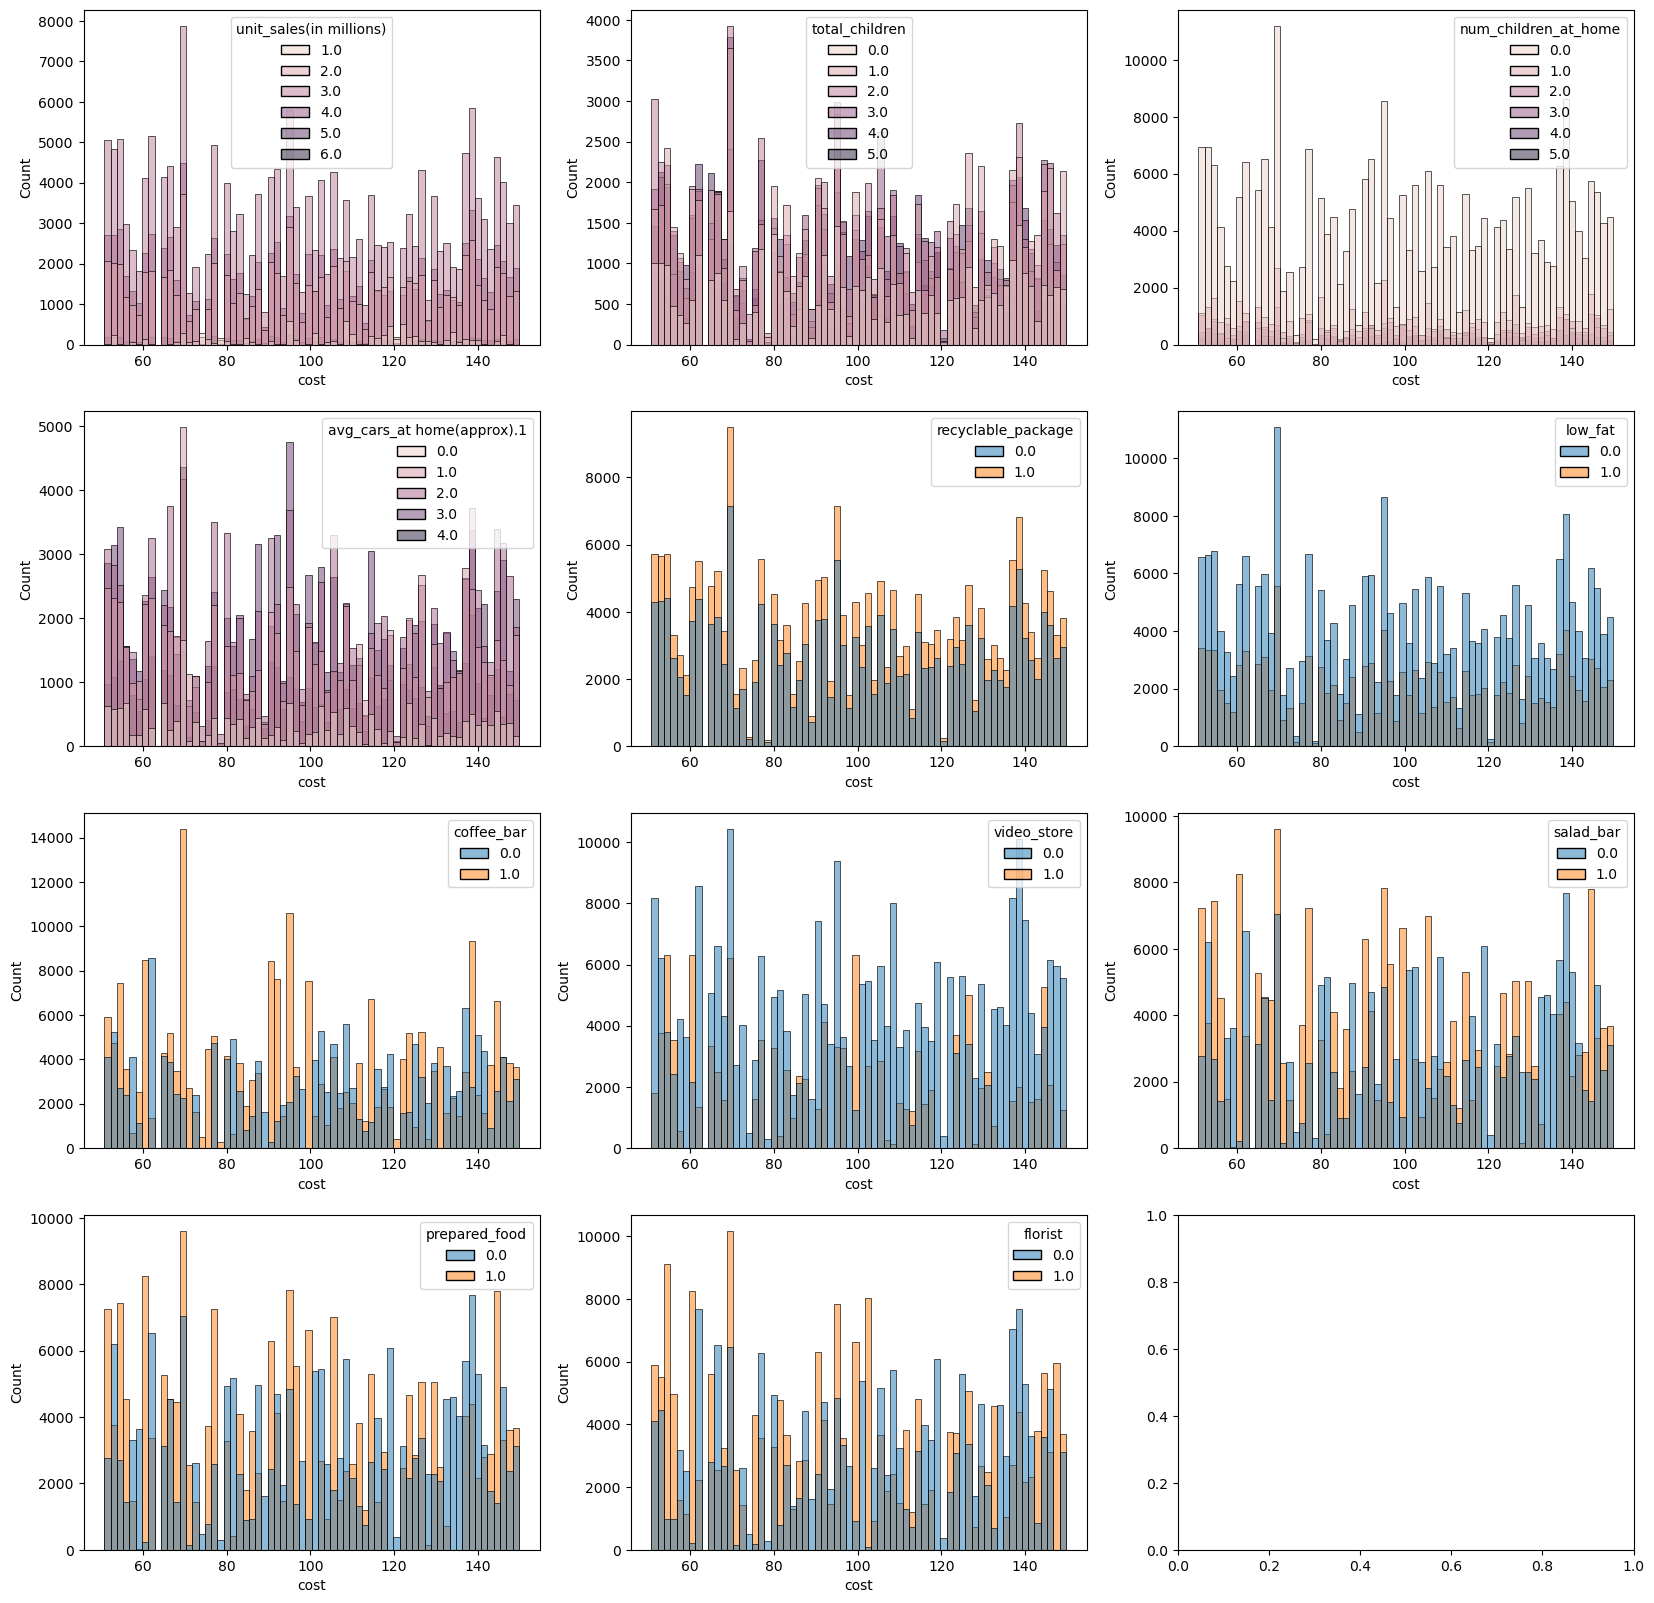

In [10]:
fig, axes = plt.subplots(4, 3, figsize=( 20,20 ))
for i,col in enumerate(cat):
    ax = axes[ i//axes.shape[1], i%axes.shape[1] ]
    sns.histplot(data = train_df, x = 'cost', hue = col, ax = ax)
    

# Feature Importance and Permutation Importance

In [11]:
train_fi = train_df.drop(columns = ['cost'])
target_fi = train_df['cost']

In [12]:
def plot_fi(data,ax = None,title = None):
    fi = pd.Series(data, index = train_fi.columns).sort_values(ascending = True)
    fi.plot(kind = 'barh', ax = ax)

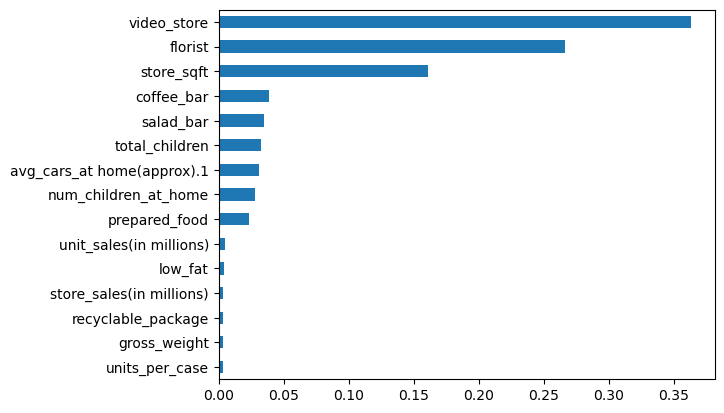

In [13]:
import xgboost as xgb
from sklearn.inspection import permutation_importance

x_train, x_test, y_train, y_test = train_test_split(train_fi,target_fi, test_size = 0.2)


params = {'learning_rate': 0.2456172216493356,
 'max_depth': 10,
 'lambda': 0.0023120639864473262,
 'alpha': 0.5848465230832824,
 'colsample_bytree': 0.9966638720347625,
 'min_child_weight': 0,
 'sampling_method': 'uniform',
 'tree_method': 'gpu_hist',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

model = xgb.XGBRegressor(**params)
model.fit(x_train,y_train)
plot_fi(model.feature_importances_)

In [14]:
r = permutation_importance(model, x_test, y_test, n_repeats = 1, random_state = 46)

units_per_case               -0.000011
low_fat                       0.000006
gross_weight                  0.000028
recyclable_package            0.000031
store_sales(in millions)      0.000393
unit_sales(in millions)       0.001385
num_children_at_home          0.020070
coffee_bar                    0.027762
video_store                   0.033093
salad_bar                     0.035740
avg_cars_at home(approx).1    0.037687
total_children                0.041899
prepared_food                 0.052454
store_sqft                    0.255024
florist                       0.257845
dtype: float64

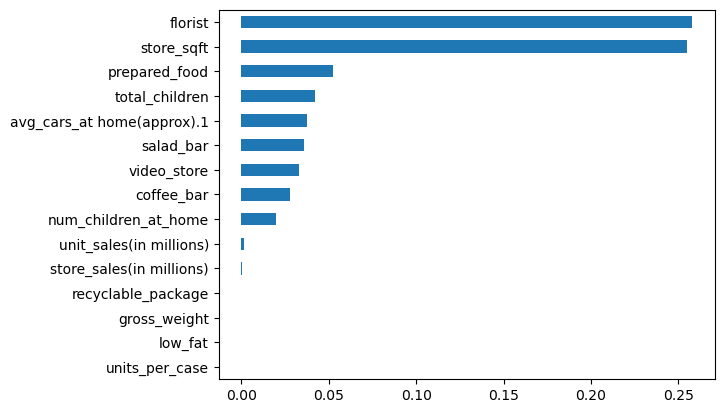

In [15]:
fi = pd.Series(r['importances'].reshape(15,), index = train_fi.columns).sort_values(ascending = True)
fi.plot(kind = 'barh')
fi

In [16]:
cols_to_drop = ['store_sales(in millions)','gross_weight','units_per_case','recyclable_package','unit_sales(in millions)','low_fat','prepared_food']

In [17]:
train_df.drop(columns = cols_to_drop, inplace = True)
test_df.drop(columns = cols_to_drop, inplace = True)

# Feature Engineering

In [18]:
#https://www.kaggle.com/competitions/playground-series-s3e11/discussion/396291
def fe(data):
#     data['revenue_per_unit'] = data['store_sales(in millions)'] / data['unit_sales(in millions)']
#     data['sales_per_sqft'] = data['store_sales(in millions)'] / data['store_sqft']
#     data['unit_per_sqft'] = data['unit_sales(in millions)'] / data['store_sqft']
#    data['child_ratio'] = data['total_children'] / data['num_children_at_home']
#     data['weight_per_unit'] = data['gross_weight'] / data['unit_sales(in millions)']
    data = data.replace([np.inf, -np.inf], 10)
    return data

train_fe = fe(train_df)
test_fe = fe(test_df)

# Outlier Detection with ADJ Boxplot

In [19]:
# !pip install robustats
# from IPython.display import clear_output
# clear_output()

In [20]:
# import robustats

# def adj_boxplot_outlier_romover(feature):
#     feature = feature.copy()
#     MC = robustats.medcouple(feature.to_list())
#     Q1 = feature.quantile(.25)
#     Q3 = feature.quantile(.75)
#     l_bound = Q1 - (1.5*np.exp(-4*MC))
#     up_bound = Q3 + (1.5*np.exp(3*MC))
    
#     outlier = (feature < l_bound) | (feature > up_bound)
#     # replace them with median
#     feature[outlier] = feature.median()

#     return feature

In [21]:
# # Right skew on the store sales
# train_fe['store_sales(in millions)'] = adj_boxplot_outlier_romover(train_fe['store_sales(in millions)'])

# Modeling

In [22]:
import optuna

train = train_fe.drop(columns = ['cost'])
target = train_fe['cost']

## Searching the best parameter with optuna
x_train, x_test, y_train, y_test = train_test_split(train,target, test_size = 0.2)
d_train = xgb.DMatrix(x_train,y_train)
d_test = xgb.DMatrix(x_test,y_test)

glob_params = {
    'tree_method': 'gpu_hist',
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle'
}

def objective(trial):
    params = {
        'verbosity':0,
        'n_estimators': trial.suggest_int("n_estimators", 150, 1500),
        'learning_rate': trial.suggest_float('learning_rate',1e-10,1.0),
        'max_depth':trial.suggest_int('max_depth', 3, 12),
#        'gamma':trial.suggest_float('gamma',0,8),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree',1e-5,1.0),
        'min_child_weight':trial.suggest_int('min_child_weight',0,1),
        'booster':trial.suggest_categorical("booster", ["dart", "gbtree",'gblinear']),
        'sampling_method': trial.suggest_categorical('sampling_method',['uniform','gradient_based']),
        'grow_policy': trial.suggest_categorical('grow_policy',['depthwise','lossguide']),
#         'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
#         'reg_lambda': trial.suggest_float("reg_lambda", 0, 1),
    }
    params.update(glob_params)
    sch_prm = xgb.train(params, d_train, num_boost_round = 100,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=False
                       )
    
    return sch_prm.best_score

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials = 500,)

In [23]:
best_params = {'n_estimators': 378,
 'learning_rate': 0.9319687783879956,
 'max_depth': 12,
 'lambda': 0.02022953533538882,
 'alpha': 9.277352577569814e-07,
 'colsample_bytree': 0.7477567097593131,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise',
 'tree_method': 'gpu_hist',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}
best_params.update(glob_params)
best_params

{'n_estimators': 378,
 'learning_rate': 0.9319687783879956,
 'max_depth': 12,
 'lambda': 0.02022953533538882,
 'alpha': 9.277352577569814e-07,
 'colsample_bytree': 0.7477567097593131,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise',
 'tree_method': 'gpu_hist',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [24]:
num_folds = 10
loglosses = []
final_preds = np.zeros(len(test_fe))
kf = KFold(n_splits=num_folds, shuffle = True, random_state = 1042)
for fold, (trn_idx, val_idx) in enumerate(kf.split(train,target)):
    print('-'*20, 'Fold:', fold + 1, '-'*20)
    X_train, X_test = train.iloc[trn_idx], train.iloc[val_idx]
    y_train, y_test = target.iloc[trn_idx], target.iloc[val_idx]
    
    d_train = xgb.DMatrix(X_train,y_train)
    d_test = xgb.DMatrix(X_test,y_test)
    
    model =  xgb.train(best_params, d_train, num_boost_round = 200,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=True
                       )
#     preds = model.predict(d_test)
#     logloss = metrics.log_loss(y_test, preds)
#     loglosses.append(logloss)
#     print(f'Logloss: {logloss}')
    
    preds = model.predict(xgb.DMatrix(test_fe))
    final_preds += preds / num_folds
    

# print(f'The average of all log losses: {np.mean(loglosses)}')


-------------------- Fold: 1 --------------------
[07:25:24] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	valid-rmsle:3.61096
[1]	valid-rmsle:3.06574
[2]	valid-rmsle:2.53746
[3]	valid-rmsle:2.03137
[4]	valid-rmsle:1.55531
[5]	valid-rmsle:1.12187
[6]	valid-rmsle:0.75121
[7]	valid-rmsle:0.47866
[8]	valid-rmsle:0.34007
[9]	valid-rmsle:0.30752
[10]	valid-rmsle:0.30490
[11]	valid-rmsle:0.30037
[12]	valid-rmsle:0.29988
[13]	valid-rmsle:0.29911
[14]	valid-rmsle:0.29896
[15]	valid-rmsle:0.29666
[16]	valid-rmsle:0.29580
[17]	valid-rmsle:0.29562
[18]	valid-rmsle:0.29521
[19]	valid-rmsle:0.29507
[20]	valid-rmsle:0.29507
[21]	valid-rmsle:0.29417
[22]	valid-rmsle:0.29412
[23]	valid-rmsle:0.294

In [25]:
# sub_preds = np.vstack(final_preds)
final_preds.shape

(240224,)

In [26]:
submission = pd.DataFrame(
    {
        'id': test_['id'],
        'cost': final_preds,
    }
)
submission

,id,cost
0,360336,90.237152
1,360337,94.164127
2,360338,94.401175
3,360339,98.620265
4,360340,78.396607
...,...,...
240219,600555,101.517696
240220,600556,90.050686
240221,600557,94.401175
240222,600558,105.237998


In [27]:
submission.to_csv("/kaggle/working/submission.csv", index = False)